### Introduction

Link/edge prediction demo for cora dataset (homegeneous network) where all nodes are papers and edges between nodes are citation links, e.g., paper A cites paper B. 

Each paper has a **subject** attribute with one of 7 values denoting the subject area of the paper.

This demo notebook **demonstrates how to predict citation links/edges between papers** using the random walk-based representation learning method Node2Vec.

**References:** 

**[1]** Node2Vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016. 

In [1]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
from stellargraph.data import EdgeSplitter
from utils.cl_arguments_parser import parse_args
from utils.read_graph import read_graph
from utils.predictors import *
from collections import Counter
import multiprocessing

%matplotlib inline

In [2]:
# Default parameters for Node2Vec
parameters = {
    "p": 1.,  # Parameter p
    "q": 1.,  # Parameter q
    "dimensions": 128,  # dimensionality of node2vec embeddings
    "num_walks": 10,  # Number of walks from each node
    "walk_length": 80,  # Walk length
    "window_size": 10,  # Context size for word2vec
    "iter": 1,  # number of SGD iterations (epochs)
    "workers": multiprocessing.cpu_count(),  # number of workers for word2vec
    "weighted": False,  # is graph weighted?
    "directed": False,  # are edges directed?
}

### Load the dataset

The dataset is the citation network Cora.

It can be downloaded by clicking [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz)

The following is the description of the dataset from the publisher,

> The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. The README file in the dataset provides more details. 

For this demo, we ignore the word vector associated with each paper. We are only interested in the network structure.

Download and unzip the cora.tgz file to a location on your computer. For the purposes of this demo, we are only interested in the **cora.cites** file that is a representation of the graph as an edge list.

We assume that the dataset is stored in the directory

`~/data/cora/cora.cites`

In [3]:
cora_location = os.path.expanduser("~/data/cora/cora.cites")
dataset_name = 'cora'
g_nx = read_graph(graph_file=cora_location, dataset_name=dataset_name)

# Select the largest connected component. For clarity we ignore isolated
# nodes and subgraphs; having these in the data does not prevent the
# algorithm from running and producing valid results.
g_nx_ccs = (g_nx.subgraph(c).copy() for c in nx.connected_components(g_nx))
g_nx = max(g_nx_ccs, key=len)
print("Largest subgraph statistics: {} nodes, {} edges".format(
    g_nx.number_of_nodes(), g_nx.number_of_edges()))


Graph statistics: 2708 nodes, 5278 edges
Largest subgraph statistics: 2485 nodes, 5069 edges


### Construct train and test splits of the input data

We are going to tackle link prediction as a supervised learning problem whereas we are going to train a binary classifier to predict a link, or not, between to nodes in the graph. 

For supervised classification, we need a training set of positive and negative examples of links and a corresponding **train** graph with the positive links removed; this graph is used for representation learning.

For evaluation, we will use a hold out dataset, that is a set of positive and negative examples of links and a corresponding **test** graph.

We are going to split our input graph into a **train** and **test** graphs using the EdgeSplitter class in stellar.data.edge_splitter. We are going to use the **train** graph for training the predictive model (a binary classifier that given two nodes it will predict whether a link between these two nodes should exist or not) and the **test** graph for evaluating the predictive model's performance on hold out data. 

Each graph will have the same number of nodes as the input graph but the number of edges will differ as some of the edges will be removed during each split and used as the positive samples for training the link prediction classifier.

In [4]:
# Test graph and edge test data
edge_splitter_test = EdgeSplitter(g_nx)
g_test, edge_data_ids_test, edge_data_labels_test = edge_splitter_test.train_test_split( 
    p=0.1, method='global'
)

# Train graph and edge train data
edge_splitter_train = EdgeSplitter(g_test, g_nx)
g_train, edge_data_ids_train, edge_data_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method='global'
)

** Sampled 258 positive and 258 negative edges. **
** Sampled 232 positive and 232 negative edges. **


### Convert graphs

The node2vec reference implementation requires that the given graph is undirected and homogeneous. We cast the **train** and **test** graphs accordingly.

In [5]:
# Train and Test graphs should be of type nx.Graph
g_test = nx.Graph(g_test)
g_train = nx.Graph(g_train)

### Train the link prediction model and evaluate on test data

We are going to train a link prediction classifier in three steps. 
1. We use Node2Vec, [1], to calculate node embeddings. These embeddings are learned in such a way to ensure that nodes that are close in the graph remain close in the embedding space.
2. We calculate link/edge embeddings for the positive and negative edge samples by applying a binary operator on the embeddings of the source and target nodes of each sampled edge. We consider 4 different operators, hadamard, l1, l2, and average; the paper in [1] provides a detailed description of these operators. All operators produce link embeddings that have equal dimensionality to the input node embeddings (128 dimensions for our example.) 
3. Given the embeddings of the positive and negative examples, we train a logistic regression classifier to predict a binary value indicating whether an edge between two nodes should exist or not.
4. We evaluate the performance of the link classifier for each of the 4 operators on the training data and select the best performing one. The selected operator is used to predict the hold out, test, data with node embeddings calculated on the **test** graph.


In [6]:
train_fl, test_fl, clf_edge = train_homogeneous_graph(
    g_train=g_train,
    g_test=g_test,
    output_node_features='embeddings.emb',
    edge_data_ids_train=edge_data_ids_train,
    edge_data_labels_train=edge_data_labels_train,
    edge_data_ids_test=edge_data_ids_test,
    edge_data_labels_test=edge_data_labels_test,
    parameters=parameters,
)

(Node2VecFeatureLearning) Time for random walks 9 seconds
(Node2VecFeatureLearning) Time for learning embeddings 9 seconds.
Total time for fit() 18.606926679611206 seconds
Operator: h Score (ROC AUC on test set of edge_data): 0.940
Operator: avg Score (ROC AUC on test set of edge_data): 0.567
Operator: l1 Score (ROC AUC on test set of edge_data): 0.941
Operator: l2 Score (ROC AUC on test set of edge_data): 0.950
(Node2VecFeatureLearning) Time for random walks 12 seconds
(Node2VecFeatureLearning) Time for learning embeddings 11 seconds.
Total time for fit() 23.373923778533936 seconds
Prediction score (ROC AUC): 0.9445345832582177

  **** Scores on test set ****

     Operator: l2  Score (ROC AUC): 0.94

  ****************************


### Visualise representations of link embeddings

Learned link embeddings have 128 dimensions but for visualisation we project them down to 2 dimensions using the PCA algorithm ([link](https://en.wikipedia.org/wiki/Principal_component_analysis)). 

Green points represent positive edges and red points represent negative (no edge should exist between the corresponding vertices) edges.

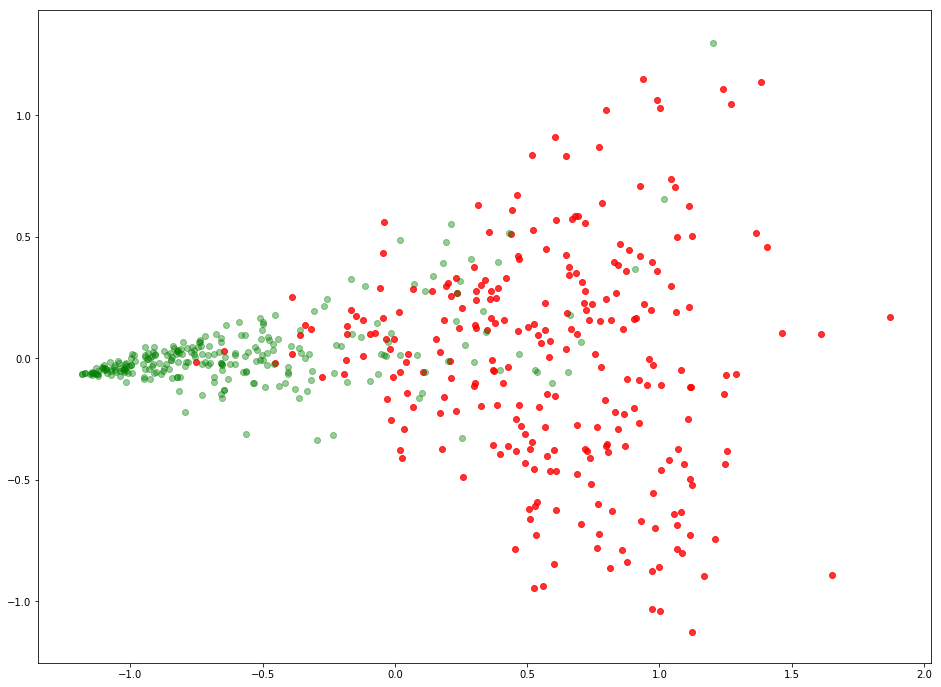

In [7]:
# Calculate edge features for test data
edge_data = (edge_data_ids_test, edge_data_labels_test)
X, y = test_fl.transform(edge_data, 'l2')

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X)

# plot the 2-dimensional points
red = y == 0
green = y == 1
plt.figure(figsize=(16,12))
plt.scatter(X_transformed[red, 0], X_transformed[red, 1], c="r", alpha=0.8)
plt.scatter(X_transformed[green, 0], X_transformed[green, 1], c="g", alpha=0.4)

This example has demonstrated how to use the `stellargraph` library to build a link prediction algorithm for homogeneous graphs using the Node2Vec, [1], representation learning algorithm.